In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from random import randrange
import itertools

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

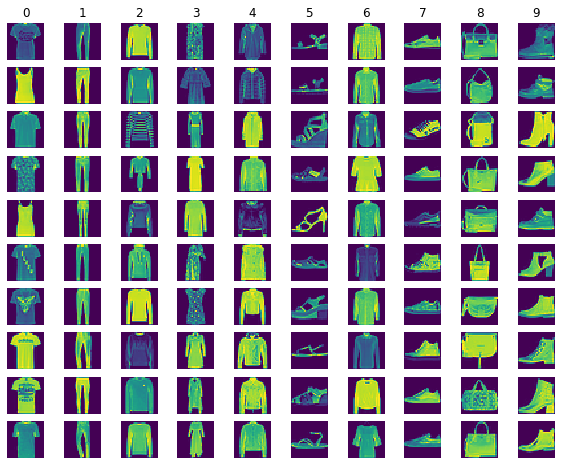

In [3]:
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = 10
samples = 10

plt.figure(figsize = (10,8))

for y, cls in enumerate(classes):
    indices = np.nonzero([i == y for i in y_train])
    indices = np.random.choice(indices[0], samples, replace=False)
    for i , index in enumerate(indices):
        plt_index = i * num_classes + y + 1
        plt.subplot(samples, num_classes, plt_index)
        plt.axis("off")
        plt.imshow(X_train[index].reshape((28, 28)))
        if i == 0:
            plt.title(cls)
        
plt.show()

In [4]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
num_labels = 10

In [5]:
# reshuffle data

y_train = np.reshape(y_train, (-1, 1))
data_set = np.append(X_train, y_train, axis=1)
np.random.shuffle(data_set)
X_train = np.delete(data_set, 784, 1)
y_train = np.delete(data_set, np.s_[:784], 1)
y_train = y_train.flatten()

In [6]:
# # global centering
X_train = X_train - X_train.mean(axis=0)
X_test = X_test - X_test.mean(axis=0)


# local centering
X_train -= X_train.mean(axis=1).reshape(X_train.shape[0], -1)
X_test -= X_test.mean(axis=1).reshape(X_test.shape[0], -1)

In [7]:
# Min max scaler
def scaler(X):
    max = np.amax(X)
    min = np.amin(X)
    scale = (max - min) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = scale * X + min - X.min(axis=0) * scale
    return X_scaled

In [8]:
def data_processing(X, y):
    
    # Scale data with min max scaler
    X = scaler(X)
    
    # Adding one more column at front for intercept
    X = np.c_[np.ones((X.shape[0], 1)), X]
    y = y[:, np.newaxis]
    
    # Initialise theta with 0
    theta = np.zeros((X.shape[1], 1))
    return X, y, theta

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def probability(theta, x):
    return sigmoid(x @ theta)

def costs(theta, x, y):
    m = x.shape[0]
    predictions = probability(theta, x)
    
    # Avoid divide by 0 warning during runtime
    predictions[predictions == 1] = 0.9999
    predictions[predictions == 0] = 0.0001
    
    # Cost function with regularisation
    cost = -(1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    reg_cost= cost + 1/(2*m) * sum(theta**2)
    
    return reg_cost

def gradient(theta, x, y):
    # Compute the gradient
    m = x.shape[0]
    grad =  (1 / m) * np.dot(x.T, probability(theta, x) - y)
    grad[1:] = grad[1:] + (1 / m) * theta[1:]
    return grad

In [10]:
def predict(X, clf):
    X = scaler(X)
    X = np.c_[np.ones((X.shape[0], 1)), X]
    class_prob = sigmoid(X @ clf.T)
    return class_prob.argmax(axis=1)

In [11]:
def evaluate(X_test, y_test, classifiers):
    X_test, y_test, _ = data_processing(X_test, y_test)
    class_prob = sigmoid(X_test @ classifiers.T)
    y_pred = class_prob.argmax(axis=1)
    # print("Training accuracy:", str(100 * np.mean(y_pred == y_test.flatten())) + "%")
    return str(100 * np.mean(y_pred == y_test.flatten()))

In [12]:
def cross_validation(X_train, y_train, k_fold=10):
    accuracy_list = []
    for i in range(k_fold):
        m = int(len(X_train) / k_fold * i)
        n = int(len(X_train) / k_fold * (i + 1))   
        k_fold_X_train = np.delete(X_train, np.s_[m:n], axis=0)
        k_fold_y_train = np.delete(y_train, np.s_[m:n], axis=0)
        k_fold_X_test = X_train[m:n]
        k_fold_y_test = y_train[m:n]
        
        for i in range(0, num_labels):
            label = (k_fold_y_train == i).astype(int)
            classifiers[i, :] = opt.fmin_bfgs(costs, theta, gradient,(k_fold_X_train, label.flatten()), disp=0)
        class_prob = sigmoid(k_fold_X_test @ classifiers.T)
        y_pred = class_prob.argmax(axis=1)
        accuracy = 100 * np.mean(y_pred == k_fold_y_test.flatten()) 
        print('Test set index: {} to {}, accuracy {:.2f}%'.format(m, n, accuracy))
        accuracy_list.append(accuracy)
    return np.mean(accuracy_list)

In [13]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def f1_score(label, confusion_matrix):
    return 2 * precision(label, confusion_matrix)*recall(label, confusion_matrix) / \
        (precision(label, confusion_matrix) + recall(label, confusion_matrix))

def support(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return row.sum()

In [14]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Oranges):

    plt.figure(figsize = (10,8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes))
    y_tick_marks = np.arange(-0.5, len(classes))
    plt.xticks(x_tick_marks, classes)
    plt.yticks(y_tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha ="center",
                 va ="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [15]:
def compute_confusion_matrix(y_test, y_pred):
    c_matrix = np.zeros((10, 10))
    for a, p in zip(y_test, y_pred):
        c_matrix[int(a)][int(p)] += 1
    return c_matrix

In [ ]:
# Data processing and initialise theta
X_train, y_train, theta = data_processing(X_train, y_train)

# Initialise classifier with all 0 in a 10 x 785 matrix
classifiers = np.zeros(shape=(num_labels, X_train.shape[1]))

# k_fold Cross validation
# k = 10 10 fold cross validation to verify the realibilty of the classifier
# k = 1 for final classifier
k_fold = 1
accuracy = []
if k_fold > 1:
    print(cross_validation(X_train, y_train, k_fold=k_fold))
else:
    for i in range(0, num_labels):
        label = (y_train == i).astype(int)
        print(f'Iteration for label {i}...')
        classifiers[i, :] = opt.fmin_bfgs(costs, theta, gradient,(X_train, label.flatten()), disp=0)
    accuracy.append(evaluate(X_test, y_test, classifiers))

print('Training accuracy: {}%'.format(np.mean(list(map(float, accuracy)))))

Iteration for label 0...
Iteration for label 1...


In [ ]:
y_pred = predict(X_test, classifiers)
cnf_matrix = compute_confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=list(set(y_test)),
                      title='Confusion matrix')

In [ ]:
# Print Classification Report
print(f"{'Label'}{'precision':>10} {'recall':>5} {'f1-score':>5} {'support':>5}")
for label in range(10):
    print(f"{label:5d} {precision(label, cnf_matrix):9.3f} {recall(label, cnf_matrix):6.3f} \
{f1_score(label, cnf_matrix):8.3f}{support(label, cnf_matrix):8.0f}")